# Food Classification

This project implemented food classification using images with pretrained model Resnet50

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

In [2]:
ds = load_dataset("AkshilShah21/food_images")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 19098
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 4775
    })
})


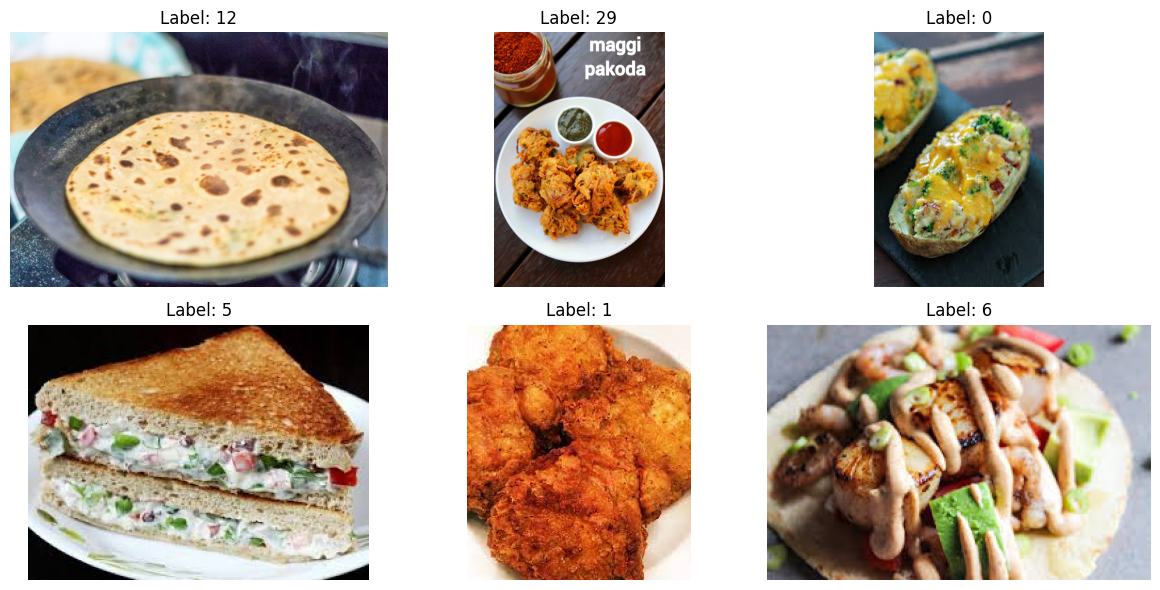

In [3]:
def show_sample_images(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        sample = dataset['train'][i]
        image = sample['image']  
        plt.subplot(2, n//2, i+1)
        plt.imshow(image)
        plt.title(f"Label: {sample['label']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(ds)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
class FoodDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_dataset = FoodDataset(ds['train'], transform=transform)
test_dataset = FoodDataset(ds['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

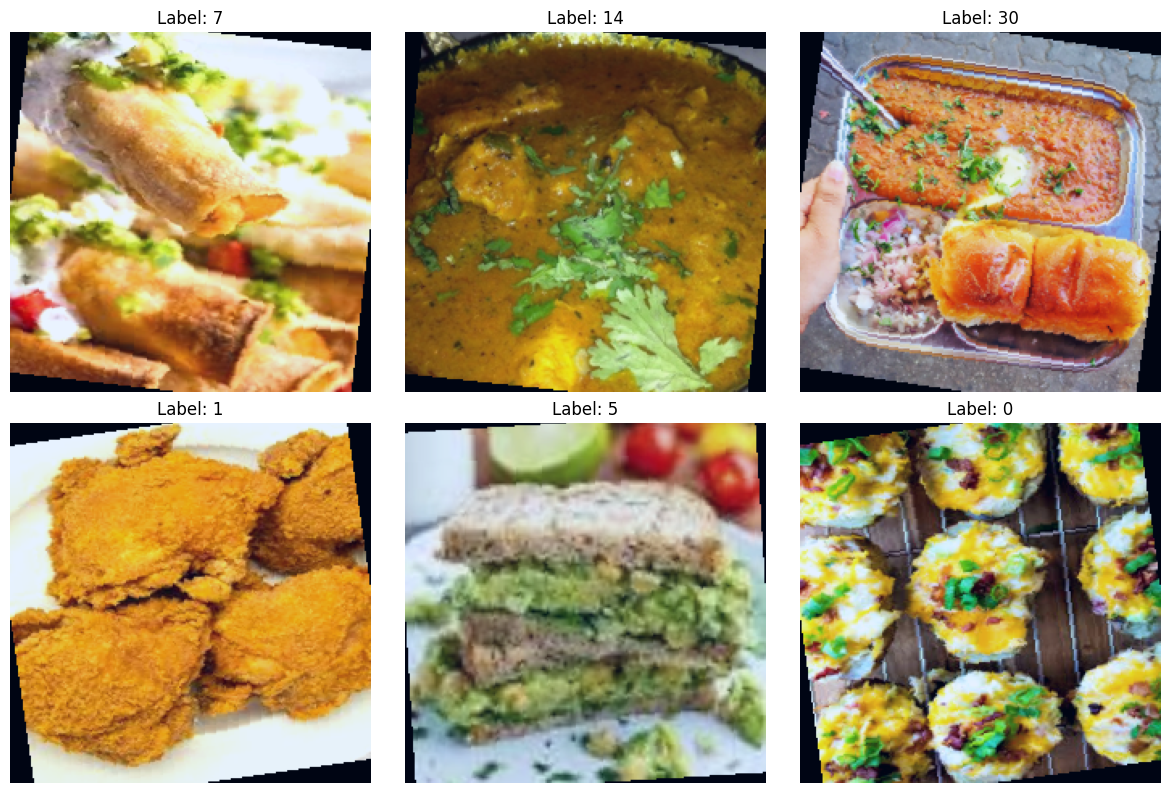

In [7]:
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(12, 8))
    for i in range(min(6, len(images))):
        plt.subplot(2, 3, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_batch(train_loader)

In [8]:
num_classes = len(set(ds['train']['label']))

model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

c:\Users\petronilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\petronilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [16]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

num_epochs = 10
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    loss, accuracy = train_epoch(model, train_loader, criterion, optimizer)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')
    scheduler.step(loss)
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model saved!')
    print('-' * 50)

Epoch 1/10


 39%|███▉      | 233/597 [26:10<40:00,  6.59s/it]  c:\Users\petronilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
 52%|█████▏    | 308/597 [33:53<28:18,  5.88s/it]c:\Users\petronilo\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 597/597 [1:02:51<00:00,  6.32s/it]


Loss: 2.9643, Accuracy: 11.81%
Model saved!
--------------------------------------------------
Epoch 2/10


100%|██████████| 597/597 [1:00:59<00:00,  6.13s/it]


Loss: 2.6429, Accuracy: 18.09%
Model saved!
--------------------------------------------------
Epoch 3/10


100%|██████████| 597/597 [1:00:40<00:00,  6.10s/it]


Loss: 2.5006, Accuracy: 21.76%
Model saved!
--------------------------------------------------
Epoch 4/10


100%|██████████| 597/597 [1:00:07<00:00,  6.04s/it]


Loss: 2.3475, Accuracy: 26.37%
Model saved!
--------------------------------------------------
Epoch 5/10


100%|██████████| 597/597 [59:50<00:00,  6.01s/it]


Loss: 2.2177, Accuracy: 31.05%
Model saved!
--------------------------------------------------
Epoch 6/10


100%|██████████| 597/597 [59:51<00:00,  6.02s/it] 


Loss: 2.0648, Accuracy: 36.37%
Model saved!
--------------------------------------------------
Epoch 7/10


100%|██████████| 597/597 [1:00:07<00:00,  6.04s/it]


Loss: 1.9438, Accuracy: 41.04%
Model saved!
--------------------------------------------------
Epoch 8/10


100%|██████████| 597/597 [59:57<00:00,  6.03s/it]


Loss: 1.8298, Accuracy: 44.32%
Model saved!
--------------------------------------------------
Epoch 9/10


100%|██████████| 597/597 [59:51<00:00,  6.02s/it]


Loss: 1.7222, Accuracy: 47.92%
Model saved!
--------------------------------------------------
Epoch 10/10


100%|██████████| 597/597 [59:53<00:00,  6.02s/it]

Loss: 1.6336, Accuracy: 50.68%
Model saved!
--------------------------------------------------


In [17]:
# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

additional_epochs = 10  

for epoch in range(num_epochs, num_epochs + additional_epochs):
    print(f'Epoch {epoch+1}/{num_epochs + additional_epochs}')
    loss, accuracy = train_epoch(model, train_loader, criterion, optimizer)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')
    scheduler.step(loss)
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model saved!')
    print('-' * 50)

Epoch 11/20


100%|██████████| 597/597 [58:26<00:00,  5.87s/it]


Loss: 1.5242, Accuracy: 54.05%
Model saved!
--------------------------------------------------
Epoch 12/20


100%|██████████| 597/597 [1:00:05<00:00,  6.04s/it]


Loss: 1.4607, Accuracy: 56.58%
Model saved!
--------------------------------------------------
Epoch 13/20


100%|██████████| 597/597 [1:02:12<00:00,  6.25s/it]


Loss: 1.3767, Accuracy: 58.73%
Model saved!
--------------------------------------------------
Epoch 14/20


100%|██████████| 597/597 [59:59<00:00,  6.03s/it] 


Loss: 1.3359, Accuracy: 60.12%
Model saved!
--------------------------------------------------
Epoch 15/20


100%|██████████| 597/597 [1:01:48<00:00,  6.21s/it]


Loss: 1.2518, Accuracy: 62.79%
Model saved!
--------------------------------------------------
Epoch 16/20


100%|██████████| 597/597 [1:04:59<00:00,  6.53s/it]


Loss: 1.2126, Accuracy: 63.39%
Model saved!
--------------------------------------------------
Epoch 17/20


100%|██████████| 597/597 [1:03:32<00:00,  6.39s/it]


Loss: 1.1480, Accuracy: 65.85%
Model saved!
--------------------------------------------------
Epoch 18/20


100%|██████████| 597/597 [1:05:48<00:00,  6.61s/it]


Loss: 1.1057, Accuracy: 67.14%
Model saved!
--------------------------------------------------
Epoch 19/20


100%|██████████| 597/597 [1:14:00<00:00,  7.44s/it]


Loss: 1.0755, Accuracy: 68.08%
Model saved!
--------------------------------------------------
Epoch 20/20


100%|██████████| 597/597 [1:03:47<00:00,  6.41s/it]


Loss: 1.0199, Accuracy: 69.88%
Model saved!
--------------------------------------------------


In [20]:
# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

additional_epochs = 1  

for epoch in range(20, 20 + additional_epochs):
    print(f'Epoch {epoch+1}/{20 + additional_epochs}')
    loss, accuracy = train_epoch(model, train_loader, criterion, optimizer)
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%')
    scheduler.step(loss)
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model saved!')
    print('-' * 50)

Epoch 21/21


100%|██████████| 597/597 [1:05:02<00:00,  6.54s/it]


Loss: 0.9949, Accuracy: 70.75%
Model saved!
--------------------------------------------------


In [21]:
# Load the saved model weights
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# Define the evaluation function (if not already defined)
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Evaluate on the test set
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.4667, Test Accuracy: 60.31%


In [36]:
def predict_pil_image(pil_img, model, transform, class_names=None):
    image = pil_img.convert('RGB')
    img = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, predicted = outputs.max(1)
    label_idx = predicted.item()
    if class_names:
        return class_names[label_idx]
    return label_idx

# Example usage:
pil_img = Image.open('Dataset/test_images/Pizza.jpg')
result = predict_pil_image(pil_img, model, transform, class_names=None)
print("Predicted class:", result)

Predicted class: 31
